# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.library import FineXAmplitude, FineSXAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.805838178606271+0j), sigma=80, beta=-0.685945797300197, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8058+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_over)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

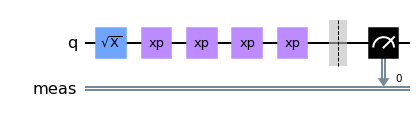

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [9]:
data_over = amp_cal.run(backend).block_for_results()

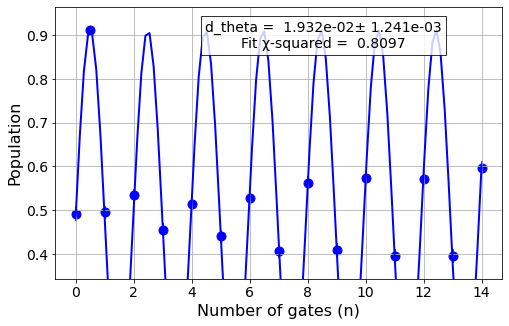

In [10]:
data_over.figure(0)

In [11]:
for result in data_over.analysis_results():
    print(result)

data_over.analysis_results(0).extra

DbAnalysisResultV1
- name: FineAmplitudeAnalysis
- value: [-0.8487543   0.01932023  0.48772088] ± [0.01942212 0.00124114 0.00400117]
- χ²: 0.8096674135302006
- quality: good
- extra: <7 items>
- device_components: ['Q0']
- verified: False


{'popt': array([-0.8487543 ,  0.01932023,  0.48772088]),
 'popt_keys': ['amp', 'd_theta', 'base'],
 'popt_err': array([0.01942212, 0.00124114, 0.00400117]),
 'pcov': array([[3.77218849e-04, 8.25154293e-06, 3.20350937e-05],
        [8.25154293e-06, 1.54044028e-06, 5.07815154e-07],
        [3.20350937e-05, 5.07815154e-07, 1.60093641e-05]]),
 'dof': 13,
 'xrange': [0.0, 14.0],
 'success': True}

In [12]:
dtheta = data_over.analysis_results(0).value.value[1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.019 rad.
Thus, scale the 0.8139+0.0000j pulse amplitude by 0.994 to obtain 0.80892+0.00000j.
Amplitude reported by the backend 0.8058+0.0000j.


### Detect an under-rotated pulse

In [13]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [14]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_under)

In [15]:
data_under = amp_cal.run(backend).block_for_results()

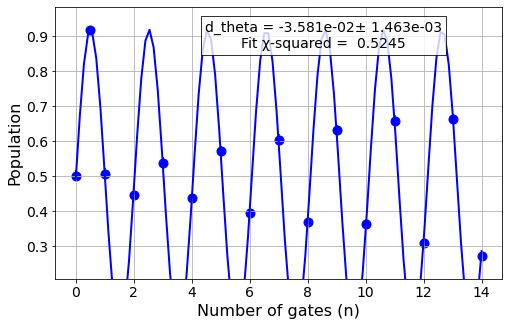

In [16]:
data_under.figure(0)

In [17]:
for result in data_under.analysis_results():
    print(result)

data_under.analysis_results(0).extra

DbAnalysisResultV1
- name: FineAmplitudeAnalysis
- value: [-0.85452691 -0.03581311  0.49077707] ± [0.01882864 0.00146343 0.00390862]
- χ²: 0.5245166332415541
- quality: good
- extra: <7 items>
- device_components: ['Q0']
- verified: False


{'popt': array([-0.85452691, -0.03581311,  0.49077707]),
 'popt_keys': ['amp', 'd_theta', 'base'],
 'popt_err': array([0.01882864, 0.00146343, 0.00390862]),
 'pcov': array([[ 3.54517566e-04, -1.63891953e-05,  3.04150603e-05],
        [-1.63891953e-05,  2.14161360e-06, -1.69085826e-06],
        [ 3.04150603e-05, -1.69085826e-06,  1.52773439e-05]]),
 'dof': 13,
 'xrange': [0.0, 14.0],
 'success': True}

In [18]:
dtheta = data_under.analysis_results(0).value.value[1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.036 rad.
Thus, scale the 0.7978+0.0000j pulse amplitude by 1.012 to obtain 0.80698+0.00000j.
Amplitude reported by the backend 0.8058+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [19]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [20]:
amp_cal = FineSXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=x90p)

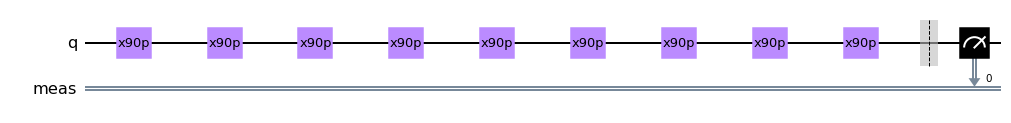

In [21]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [22]:
data_x90p = amp_cal.run(backend).block_for_results()

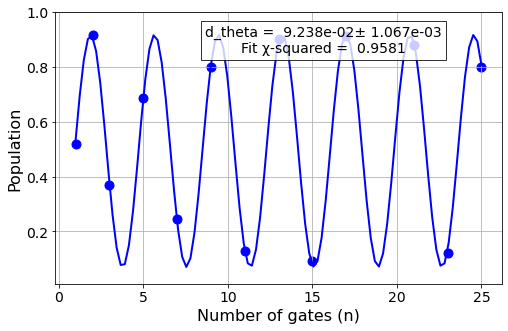

In [23]:
data_x90p.figure(0)

In [24]:
for result in data_x90p.analysis_results():
    print(result)

data_x90p.analysis_results(0).extra

DbAnalysisResultV1
- name: FineAmplitudeAnalysis
- value: [-0.84702148  0.09237962  0.49405239] ± [0.00735696 0.00106747 0.00314   ]
- χ²: 0.9580728705465782
- quality: good
- extra: <7 items>
- device_components: ['Q0']
- verified: False


{'popt': array([-0.84702148,  0.09237962,  0.49405239]),
 'popt_keys': ['amp', 'd_theta', 'base'],
 'popt_err': array([0.00735696, 0.00106747, 0.00314   ]),
 'pcov': array([[ 5.41249159e-05, -5.75463147e-07,  6.09514845e-06],
        [-5.75463147e-07,  1.13949186e-06,  2.90229197e-07],
        [ 6.09514845e-06,  2.90229197e-07,  9.85959155e-06]]),
 'dof': 10,
 'xrange': [1.0, 25.0],
 'success': True}

In [25]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = data_x90p.analysis_results(0).value.value[1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.092 rad.
Thus, scale the 0.4029+0.0000j pulse amplitude by 0.944 to obtain 0.38054+0.00000j.
Amplitude reported by the backend 0.3706-0.0772j.


Let's rerun this calibration using the updated value of the amplitude of the pi-half pulse.

In [26]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [27]:
amp_cal.set_experiment_options(schedule=x90p)

In [28]:
data_x90p = amp_cal.run(backend).block_for_results()

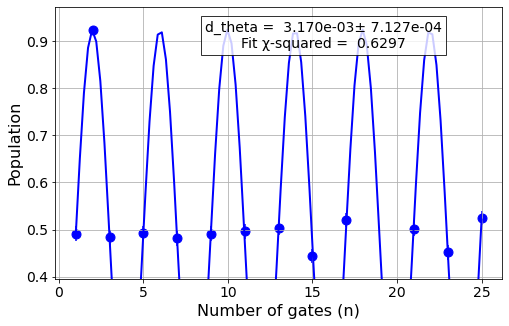

In [29]:
data_x90p.figure(0)

In [30]:
for result in data_x90p.analysis_results():
    print(result)

data_x90p.analysis_results(0).extra

DbAnalysisResultV1
- name: FineAmplitudeAnalysis
- value: [-0.87693859  0.00316993  0.48634436] ± [0.01885598 0.00071275 0.00457958]
- χ²: 0.6297421161337808
- quality: good
- extra: <7 items>
- device_components: ['Q0']
- verified: False


{'popt': array([-0.87693859,  0.00316993,  0.48634436]),
 'popt_keys': ['amp', 'd_theta', 'base'],
 'popt_err': array([0.01885598, 0.00071275, 0.00457958]),
 'pcov': array([[ 3.55547878e-04,  1.02632970e-07,  4.19511406e-05],
        [ 1.02632970e-07,  5.08007041e-07, -4.37488764e-07],
        [ 4.19511406e-05, -4.37488764e-07,  2.09725611e-05]]),
 'dof': 10,
 'xrange': [1.0, 25.0],
 'success': True}

In [31]:
dtheta = data_x90p.analysis_results(0).value.value[1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.003 rad.
Thus, scale the 0.3805+0.0000j pulse amplitude by 0.998 to obtain 0.37977+0.00000j.
Amplitude reported by the backend 0.3706-0.0772j.


In [32]:
import qiskit.tools.jupyter
%qiskit_copyright